In [ ]:
import pandas as pd
import joblib
import numpy as np
import xgboost as xgb
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, cohen_kappa_score, log_loss, classification_report, mean_squared_error, mean_absolute_error, r2_score

In [ ]:
loan_data = pd.read_csv("sri_lanka_loan_data (1).csv")

In [ ]:
loan_data.head()

,customer_id,age,gender,marital_status,job,monthly_income,housing_status,district,city,no_of_previous_loans,no_of_available_loans,total_on_time_payments,total_late_payments,risk
0,19512500002,30,Male,Married,Laborer,101999.11,Rent,Matara,Akuressa,2,3,13,9,medium
1,19752420011,25,Male,Married,Software Engineer,27574.62,Rent,Matara,Akuressa,5,0,12,0,high
2,19721590028,40,Female,Single,Doctor,14452.93,Own,Nuwara Eliya,Talawakele,1,1,12,10,medium
3,19822880034,60,Male,Single,Taxi Driver,241792.86,Other,Nuwara Eliya,Talawakele,0,2,4,1,medium
4,20001150046,58,Female,Divorced,Accountant,30189.54,Rent,Kandy,Kandy,3,1,20,0,low


In [ ]:
loan_data_new = loan_data.drop(["city", "district","customer_id"], axis=1) # or axis='columns'

In [ ]:
loan_data_new.head()

,age,gender,marital_status,job,monthly_income,housing_status,no_of_previous_loans,no_of_available_loans,total_on_time_payments,total_late_payments,risk
0,30,Male,Married,Laborer,101999.11,Rent,2,3,13,9,medium
1,25,Male,Married,Software Engineer,27574.62,Rent,5,0,12,0,high
2,40,Female,Single,Doctor,14452.93,Own,1,1,12,10,medium
3,60,Male,Single,Taxi Driver,241792.86,Other,0,2,4,1,medium
4,58,Female,Divorced,Accountant,30189.54,Rent,3,1,20,0,low


In [ ]:
categorical_cols = loan_data_new.select_dtypes(include=['object']).columns.tolist()
categorical_cols.remove('risk')
print(categorical_cols)

['gender', 'marital_status', 'job', 'housing_status']


In [ ]:
onehot_encoders = {}
processed_df = pd.DataFrame(index=loan_data_new.index)
for col in categorical_cols:
    encoder = OneHotEncoder(sparse_output=False)
    encoded_feature = encoder.fit_transform(loan_data_new[[col]])
    onehot_encoders[col] = encoder
    feature_names = encoder.get_feature_names_out([col])
    encoded_df = pd.DataFrame(encoded_feature, columns=feature_names, index=loan_data_new.index)

    processed_df = pd.concat([processed_df, encoded_df], axis=1)

    print(f"Encoded {col} into {len(feature_names)} columns")

joblib.dump(onehot_encoders, 'onehot_encoders.joblib')

Encoded gender into 2 columns
Encoded marital_status into 3 columns
Encoded job into 29 columns
Encoded housing_status into 4 columns


['onehot_encoders.joblib']

In [ ]:
numerical_cols = loan_data_new.select_dtypes(include=['number']).columns.tolist()

scaler = StandardScaler()
scaled_numerical = scaler.fit_transform(loan_data_new[numerical_cols])

# Save the scaler model
joblib.dump(scaler, 'standard_scaler.joblib')

scaled_df = pd.DataFrame(scaled_numerical, columns=numerical_cols, index=loan_data_new.index)

final_df = pd.concat([processed_df, scaled_df], axis=1)
risk_mapping = {'low': 0, 'medium': 1, 'high': 2}
final_df['risk'] = loan_data_new['risk'].map(risk_mapping)

In [ ]:
numerical_cols = loan_data_new.select_dtypes(include=['number']).columns.tolist()

# Instead of scaling, directly select the numerical columns
numerical_df = loan_data_new[numerical_cols]

# Concatenate processed_df and numerical_df
final_df = pd.concat([processed_df, numerical_df], axis=1)

risk_mapping = {'low': 0, 'medium': 1, 'high': 2}
final_df['risk'] = loan_data_new['risk'].map(risk_mapping)

In [ ]:
final_df.head()

,gender_Female,gender_Male,marital_status_Divorced,marital_status_Married,marital_status_Single,job_Accountant,job_Army Officer,job_Banker,job_Businessman,job_Chef,...,housing_status_Other,housing_status_Own,housing_status_Rent,age,monthly_income,no_of_previous_loans,no_of_available_loans,total_on_time_payments,total_late_payments,risk
0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,30,101999.11,2,3,13,9,1
1,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,25,27574.62,5,0,12,0,2
2,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,40,14452.93,1,1,12,10,1
3,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,60,241792.86,0,2,4,1,1
4,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,58,30189.54,3,1,20,0,0


In [ ]:
X = final_df.drop('risk', axis=1)
y = final_df['risk']

# Train-test split with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4, random_state=42, stratify=y
)

# Initialize XGBoost for multiclass classification
xgb_clf = xgb.XGBClassifier(
    objective='multi:softmax',       # Multiclass classification
    num_class=3,                     # Number of classes: low, medium, high
    eval_metric='mlogloss',          # Suitable for multiclass
    random_state=42,
    n_estimators=150,
    learning_rate=0.01,
    max_depth=6
)

# Train model
xgb_clf.fit(X_train, y_train)

# Predict
xgb_pred = xgb_clf.predict(X_test)

# Evaluation
print(confusion_matrix(y_test, xgb_pred))
print(f'Accuracy: {round(accuracy_score(y_test, xgb_pred), 5) * 100}%')
print(classification_report(y_test, xgb_pred, target_names=['low', 'medium', 'high']))
print(f'Cohen Kappa: {round(cohen_kappa_score(y_test, xgb_pred), 2)}')

[[ 908  575  105]
 [  68 2658  188]
 [  22  297 1179]]
Accuracy: 79.083%
              precision    recall  f1-score   support

         low       0.91      0.57      0.70      1588
      medium       0.75      0.91      0.82      2914
        high       0.80      0.79      0.79      1498

    accuracy                           0.79      6000
   macro avg       0.82      0.76      0.77      6000
weighted avg       0.81      0.79      0.78      6000

Cohen Kappa: 0.66


In [ ]:
X = final_df.drop('risk', axis=1)
y = final_df['risk']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
rf = RandomForestClassifier(random_state=70, n_estimators=150, max_depth=25)

#training
rf.fit(X_train, y_train)

#prediction based on test data
rfpred = rf.predict(X_test)
print(confusion_matrix(y_test, rfpred))
print(round(accuracy_score(y_test, rfpred), 5) * 100)
print(classification_report(y_test, rfpred))
print('Cohen kappa: ', round(cohen_kappa_score(y_test, rfpred), 2))

[[ 983  476  113]
 [ 188 2613  170]
 [  62  318 1077]]
77.883
              precision    recall  f1-score   support

           0       0.80      0.63      0.70      1572
           1       0.77      0.88      0.82      2971
           2       0.79      0.74      0.76      1457

    accuracy                           0.78      6000
   macro avg       0.79      0.75      0.76      6000
weighted avg       0.78      0.78      0.78      6000

Cohen kappa:  0.64


In [ ]:
joblib.dump(xgb_clf, 'xgb_classifier_loan.joblib')

['xgb_classifier_loan.joblib']

Predictions for the last 20 users:
User 1: Actual = 2, Predicted = 2
User 2: Actual = 1, Predicted = 1
User 3: Actual = 1, Predicted = 1
User 4: Actual = 0, Predicted = 0
User 5: Actual = 1, Predicted = 1
User 6: Actual = 1, Predicted = 1
User 7: Actual = 1, Predicted = 1
User 8: Actual = 2, Predicted = 2
User 9: Actual = 1, Predicted = 1
User 10: Actual = 1, Predicted = 1
User 11: Actual = 1, Predicted = 1
User 12: Actual = 1, Predicted = 1
User 13: Actual = 1, Predicted = 1
User 14: Actual = 0, Predicted = 1
User 15: Actual = 2, Predicted = 2
User 16: Actual = 2, Predicted = 2
User 17: Actual = 0, Predicted = 0
User 18: Actual = 0, Predicted = 1
User 19: Actual = 2, Predicted = 1
User 20: Actual = 1, Predicted = 1

Accuracy: 79.08333 %

Log Loss: 0.5573

Confusion Matrix:
[[ 908  575  105]
 [  68 2658  188]
 [  22  297 1179]]

Classification Report:
              precision    recall  f1-score   support

         low       0.91      0.57      0.70      1588
      medium       0.75    

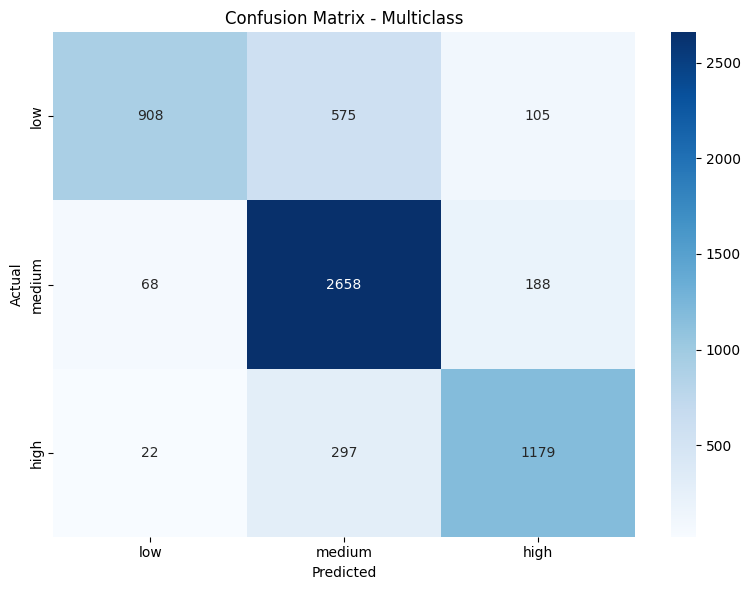

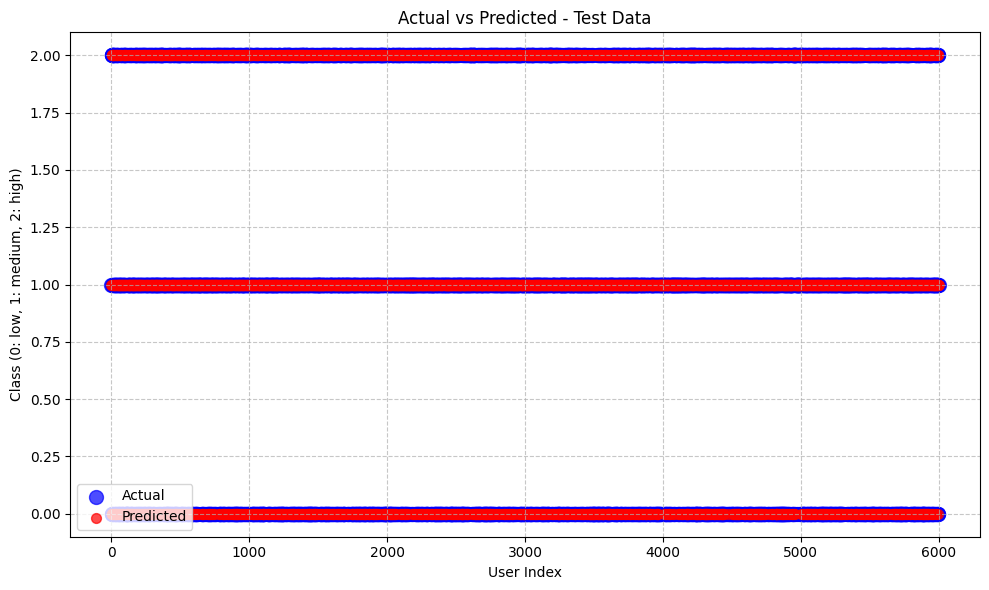

In [ ]:
X_inference = X_test
y_actual = y_test

# Load the trained multiclass model
model = joblib.load("xgb_classifier.joblib")

# Predictions
y_pred = model.predict(X_inference)
y_pred_proba = model.predict_proba(X_inference)

# Evaluation
accuracy = accuracy_score(y_actual, y_pred)
conf_matrix = confusion_matrix(y_actual, y_pred)
loss = log_loss(y_actual, y_pred_proba)

# Display predictions
print("Predictions for the last 20 users:")
for i, (actual, pred) in enumerate(zip(y_actual.tail(20), y_pred[-20:])):
    print(f"User {i+1}: Actual = {actual}, Predicted = {pred}")

print("\nAccuracy:", round(accuracy * 100, 5), "%")
print("\nLog Loss:", round(loss, 4))
print("\nConfusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(classification_report(y_actual, y_pred, target_names=['low', 'medium', 'high']))

# Visualization: Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['low', 'medium', 'high'],
            yticklabels=['low', 'medium', 'high'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Multiclass')
plt.tight_layout()
plt.show()

# Visualization: Actual vs Predicted
plt.figure(figsize=(10, 6))
plt.scatter(range(len(y_actual)), y_actual, color='blue', label='Actual', alpha=0.7, s=100)
plt.scatter(range(len(y_pred)), y_pred, color='red', label='Predicted', alpha=0.7, s=50)
plt.xlabel('User Index')
plt.ylabel('Class (0: low, 1: medium, 2: high)')
plt.title('Actual vs Predicted - Test Data')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [ ]:
loan_data_new = loan_data.drop(["city", "district","customer_id"], axis=1) # or axis='columns'
categorical_cols = loan_data_new.select_dtypes(include=['object']).columns.tolist()
categorical_cols.remove('risk')
print(categorical_cols)

onehot_encoders = {}
processed_df = pd.DataFrame(index=loan_data_new.index)
for col in categorical_cols:
    encoder = OneHotEncoder(sparse_output=False)
    encoded_feature = encoder.fit_transform(loan_data_new[[col]])
    onehot_encoders[col] = encoder
    feature_names = encoder.get_feature_names_out([col])
    encoded_df = pd.DataFrame(encoded_feature, columns=feature_names, index=loan_data_new.index)

    processed_df = pd.concat([processed_df, encoded_df], axis=1)

    print(f"Encoded {col} into {len(feature_names)} columns")

joblib.dump(onehot_encoders, 'onehot_encoders.joblib')

numerical_cols = loan_data_new.select_dtypes(include=['number']).columns.tolist()

# Instead of scaling, directly select the numerical columns
numerical_df = loan_data_new[numerical_cols]

# Concatenate processed_df and numerical_df
final_df = pd.concat([processed_df, numerical_df], axis=1)

risk_mapping = {'low': 0, 'medium': 1, 'high': 2}
final_df['risk'] = loan_data_new['risk'].map(risk_mapping)

X = final_df.drop('risk', axis=1)
y = final_df['risk']

# Train-test split with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4, random_state=42, stratify=y
)

# Initialize XGBoost for multiclass classification
xgb_clf = xgb.XGBClassifier(
    objective='multi:softmax',       # Multiclass classification
    num_class=3,                     # Number of classes: low, medium, high
    eval_metric='mlogloss',          # Suitable for multiclass
    random_state=42,
    n_estimators=150,
    learning_rate=0.01,
    max_depth=6
)

# Train model
xgb_clf.fit(X_train, y_train)

# Predict
xgb_pred = xgb_clf.predict(X_test)

# Evaluation
print(confusion_matrix(y_test, xgb_pred))
print(f'Accuracy: {round(accuracy_score(y_test, xgb_pred), 5) * 100}%')
print(classification_report(y_test, xgb_pred, target_names=['low', 'medium', 'high']))
print(f'Cohen Kappa: {round(cohen_kappa_score(y_test, xgb_pred), 2)}')

joblib.dump(xgb_clf, 'xgb_classifier_loan.joblib')

In [ ]:

# Load models
onehot_encoders = joblib.load('onehot_encoders.joblib')
xgb_clf = joblib.load('xgb_classifier_loan.joblib')

# Mapping back from prediction
risk_reverse_mapping = {0: 'low', 1: 'medium', 2: 'high'}

def preprocess_input(json_data):
    # Convert JSON to DataFrame
    input_df = pd.DataFrame([json_data])

    # Drop irrelevant columns
    input_df = input_df.drop(["city", "district", "customer_id"], axis=1, errors='ignore')

    # Separate categorical and numerical
    categorical_cols = [col for col in onehot_encoders.keys()]
    numerical_cols = input_df.select_dtypes(include=['number']).columns.tolist()

    # Encode categorical
    processed_df = pd.DataFrame(index=input_df.index)
    for col in categorical_cols:
        encoder = onehot_encoders[col]
        encoded_feature = encoder.transform(input_df[[col]])
        feature_names = encoder.get_feature_names_out([col])
        encoded_df = pd.DataFrame(encoded_feature, columns=feature_names, index=input_df.index)
        processed_df = pd.concat([processed_df, encoded_df], axis=1)

    # Append numerical
    numerical_df = input_df[numerical_cols]
    final_input_df = pd.concat([processed_df, numerical_df], axis=1)

    return final_input_df

def predict_risk(json_data):
    processed_input = preprocess_input(json_data)
    pred = xgb_clf.predict(processed_input)[0]
    return risk_reverse_mapping[pred]
